In [2]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 19 # change it with respect to the desired class
IMG_SIZE = 48 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1
from keras.applications import VGG16

In [3]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1) # this lin is doing the channel first operation

    return img

# def get_class(img_path):
#     return int(img_path.split('/')[-2])
# #     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [4]:
tra_1 = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/train_image.csv',sep=';')
tra_1.head()

,filename,classID
0,/home/atif/machine_learning_stuff/ml_image/tra...,12
1,/home/atif/machine_learning_stuff/ml_image/tra...,12
2,/home/atif/machine_learning_stuff/ml_image/tra...,12
3,/home/atif/machine_learning_stuff/ml_image/tra...,12
4,/home/atif/machine_learning_stuff/ml_image/tra...,12


In [5]:
tra_shuffle = tra_1.sample(frac=1)

In [6]:
# tra_shuffle.head()
print(type(tra_1))
print(type(tra_shuffle))
print(len(tra_1))
print(len(tra_shuffle))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
570
570


# information fetching from csv file to get image location and class ID

In [8]:
import pandas as pd
imgs = []
labels = []

train_image_csv_path = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/train_image_reduced.csv',sep=';')
train_image_csv_path_shuffle = train_image_csv_path.sample(frac=1)
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

# X_test = []
# y_test = []
i = 0
for file_name, class_id  in zip(list(train_image_csv_path_shuffle['filename']), list(train_image_csv_path_shuffle['classID'])):
#     print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
#     img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
    img_path = os.path.join(file_name)
#     print(img_path)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    img = preprocess_img(io.imread(img_path))
    imgs.append(img)
    class_id_int = int(class_id)
    labels.append(class_id_int)
    
# X_test = np.array(X_test)
# y_test = np.array(y_test)

In [9]:
print(len(imgs))

570


In [10]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (570, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (570, 19)  type:  <class 'numpy.ndarray'>


In [11]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 46, 46)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 23, 23)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 21, 21)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 10, 10)       0         
__________

In [13]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [14]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("current time:", current_time)

current time: 2019-10-31 10:38:02


In [15]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 50
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2, #shuffle=True,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+str(current_time)+'_new_image_reduced_CSV_PROCESS_model_epoch_'+str(epochs)+'.h5', save_best_only=True)])

Train on 456 samples, validate on 114 samples
Epoch 1/50
 - 2s - loss: 2.9442 - acc: 0.0504 - val_loss: 2.9440 - val_acc: 0.0614
Epoch 2/50
 - 1s - loss: 2.9422 - acc: 0.0526 - val_loss: 2.9433 - val_acc: 0.0877
Epoch 3/50
 - 1s - loss: 2.9353 - acc: 0.0636 - val_loss: 2.9377 - val_acc: 0.0351
Epoch 4/50
 - 1s - loss: 2.9203 - acc: 0.0702 - val_loss: 2.9088 - val_acc: 0.0351
Epoch 5/50
 - 1s - loss: 2.8853 - acc: 0.0724 - val_loss: 2.8456 - val_acc: 0.1667
Epoch 6/50
 - 1s - loss: 2.7687 - acc: 0.0943 - val_loss: 2.5681 - val_acc: 0.1404
Epoch 7/50
 - 1s - loss: 2.3236 - acc: 0.2083 - val_loss: 2.4232 - val_acc: 0.2719
Epoch 8/50
 - 1s - loss: 1.9728 - acc: 0.4386 - val_loss: 1.3007 - val_acc: 0.4912
Epoch 9/50
 - 1s - loss: 1.3265 - acc: 0.6294 - val_loss: 0.8868 - val_acc: 0.7456
Epoch 10/50
 - 1s - loss: 0.4994 - acc: 0.8443 - val_loss: 0.0943 - val_acc: 0.9825
Epoch 11/50
 - 1s - loss: 0.2361 - acc: 0.9211 - val_loss: 0.0249 - val_acc: 1.0000
Epoch 12/50
 - 1s - loss: 0.0843 - acc:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


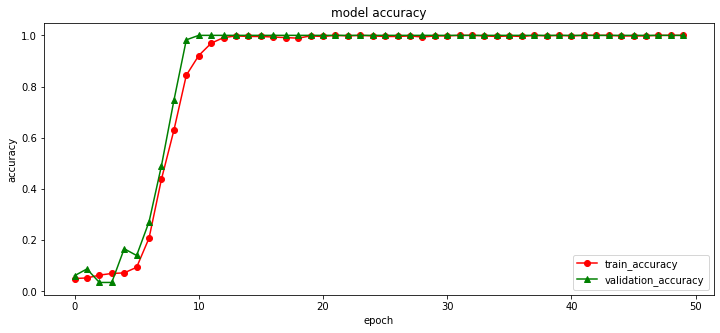

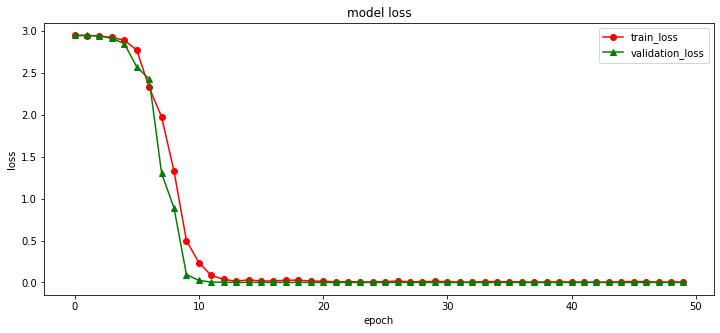

In [17]:
print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['acc'], '-o', color = 'red')
plt.plot(do_train_model.history['val_acc'],'-^', color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.savefig(path+str(current_time)+'_CSV_process_epoch_vs_accuracy.jpg')
# plt.show()

plt.figure()


print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['loss'],'-o', color = 'red')
plt.plot(do_train_model.history['val_loss'],'-^', color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.savefig(path+str(current_time)+'_CSV_process_epoch_vs_loss.jpg')
plt.rcParams['figure.figsize'] =(12,5)
plt.show()

In [36]:
from keras.models import load_model
model = load_model(path+'2019-10-29 21:16:45_new_model_csv_train_epoch_50.h5')

In [37]:
import pandas as pd
# test_file_same_number
# test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_file_16_class.csv', sep=';')
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_file_same_number.csv', sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ', file_name, '\t classId: ', class_id)
    # print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/', file_name)
    #     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)


filename:  calgonit_finish_speizalsalz (3).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (1).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (2).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (4).jpg 	 classId:  3
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  34_SM_DenkMitEdelstahlReinigerSpray_20_33_90_60_lit_cropped.jpg 	 classId:  6
filename:  denkmit_edelsthal_reiniger_spray.jpg 	 classId:  6
filename:  real_DenkMitEdelstahlReinigerSpray_right1.jpg 	 classId:  6
filename:  real_DenkMitEdelstahlReinigerSpray_right4.jpg 	 classId:  6
filename:  somat_3.jpg 	 classId:  17
filename:  somat_6.jpg 	 classId:  17
filename:  somat_7.jpg 	 classId:  17
filename:  somat_8.jpg 	 classId:  17
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_E

In [40]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape,y_test.shape)

(76, 3, 48, 48) (76,)


In [41]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.6052631578947368


In [42]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]]
<class 'numpy.ndarray'>
(19, 19)


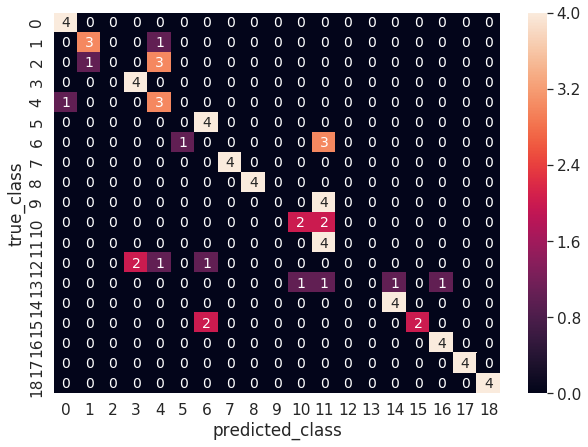

In [43]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(19),
                  range(19))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(19)
figure = ax.get_figure()    
# figure.savefig('22_OCT_sequential_model_85_percent_acc_VGG_16_channel_last.png', dpi=400)